<a href="https://colab.research.google.com/github/shahparth0007/AdvanceDataScience/blob/main/Final_Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Model:1 Image Caption Generation with CNN and LSTM**

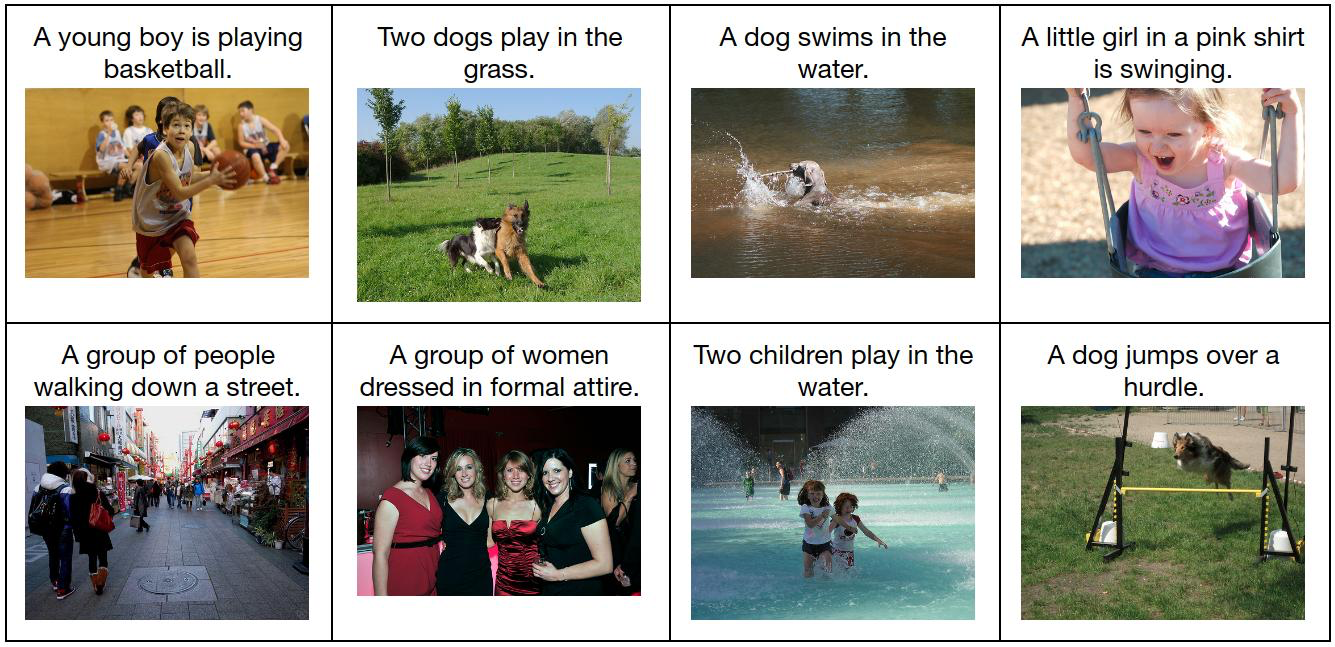

### **Problem Statement**
Given an image, we want to obtain a sentence that describes what the image consists of.

Note: We suggest you to start GPU for this session as this is a image summarization model.

***Steps:***

*   On the header click on "Runtime"
*   Click on "Change runtime type"
*   Click on "Hardware accelerator"
*   Select "GPU"
*   Click on "Save"

And you are all set to do image generation

### **1) Importing Libraries**

In [10]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# **2) Setup Data**
We have made arrangements where you can directly load the data from our kaggle accounts!



1.   First with the help of gdown the Kaggle.json file will be downloaded
2.   After which we will install kaggle library and get the data from kaggle 

Things which will get downloaded:


*   The flicker3k data with captions
*   Our trained Model V1 (With parameters: )
*   Our trained Model V2 (With parameters: )
*   The features.pkl file. (This file is the output of feature generation model VGG)

All of the above files can be seen in the contents of your google collab session!





In [11]:
!gdown --id 1jXH8vzpVy4gAkc-1lrWlwVUNF4w0B0dU
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download parthshah0007/flickerdataset
! unzip -q '/content/flickerdataset.zip' -d '/content/flickr8k/'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1jXH8vzpVy4gAkc-1lrWlwVUNF4w0B0dU
To: /content/kaggle.json
100% 69.0/69.0 [00:00<00:00, 85.3kB/s]
100% 1.17G/1.17G [00:09<00:00, 140MB/s]
100% 1.17G/1.17G [00:09<00:00, 133MB/s]


In [12]:
BASE_DIR = '/content/flickr8k/FlickerAllData/Data/'
WORKING_DIR = '/content/flickr8k/FlickerAllData/'

# **3) Loading the VGG pretrained Model**

In [13]:
# load vgg19 model
model = VGG19()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

574726144/574710816 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

# **4) Image Feature Extraction (Commented)**

Using the VGG pretrained model we will extract the features of the images.

More About VGG can be found: https://keras.io/api/applications/vgg/

Note: We have commented this as this code takes time to run!
We have already created the features and stored in features.pkl file which we downloaded from kaggle

In [ ]:
# # extract features from image

# features = {}
# directory = os.path.join(BASE_DIR, 'Images')

# for img_name in tqdm(os.listdir(directory)):
#     # load the image from file
#     img_path = directory + '/' + img_name
#     image = load_img(img_path, target_size=(224, 224))
#     # convert image pixels to numpy array
#     image = img_to_array(image)
#     # reshape data for model
#     image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#     # preprocess image for vgg
#     image = preprocess_input(image)
#     # extract features
#     feature = model.predict(image, verbose=0)
#     # get image ID
#     image_id = img_name.split('.')[0]
#     # store feature
#     features[image_id] = feature

# # store features in pickle
# pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [14]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)
print(len(features))

8091


In [15]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [16]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [17]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [18]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [19]:
# preprocess the text
clean(mapping)

In [20]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [21]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

print("There are total of:",len(all_captions)," captions")

There are total of: 40455  captions


In [22]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [27]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)

In [28]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [29]:
# create data generator to get data in batch (avoids session crash)

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# **Model 1: Long Short Term Memory**

LSTM has three gates that are input, output, forget.

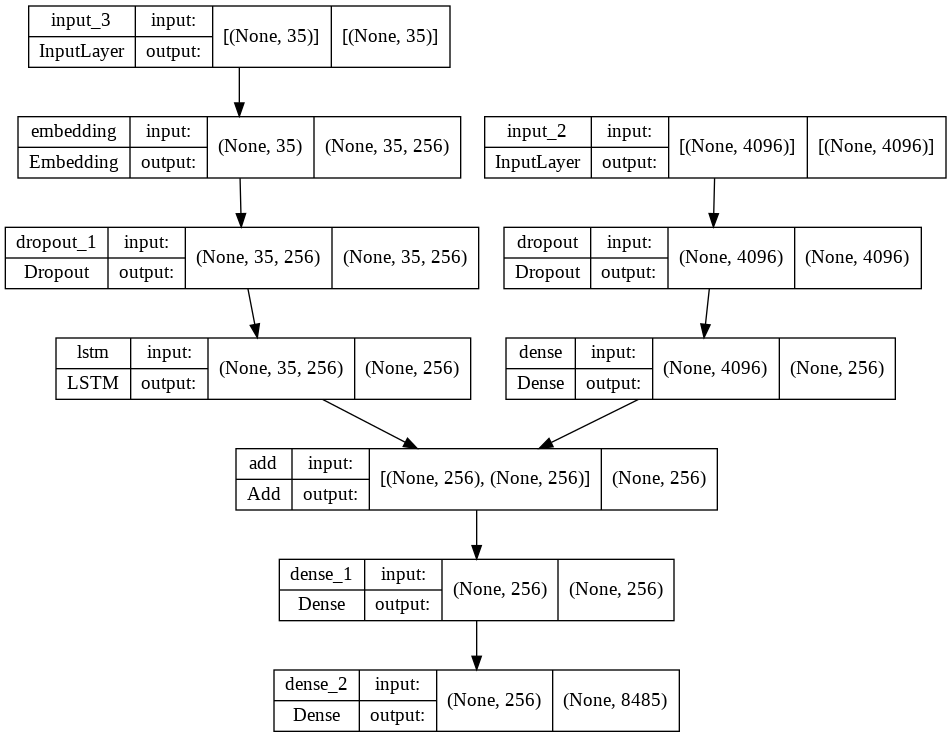

In [30]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='Adagrad')

# plot the model
plot_model(model, show_shapes=True)

## **Model Training (Commented)**

In [ ]:
# # train the model
# epochs = 1
# batch_size = 32
# steps = len(train) // batch_size

# history_loss = []

# for i in range(epochs):
#     # create data generator
#     generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
#     # fit for one epoch
#     history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     history_loss.append(history.history['loss'])

# # save the model
# model.save(WORKING_DIR+'/best_model_parameters_categorical_crossentropy_Adagrad.h5')

# # Saving the loss
# error = pd.DataFrame(history_loss)
# error.to_csv('Loss_Adam.csv')


## **Hyperparamter for LSTM**
We have changed the optimizer for LSTM we are using 'Adam' in the below model

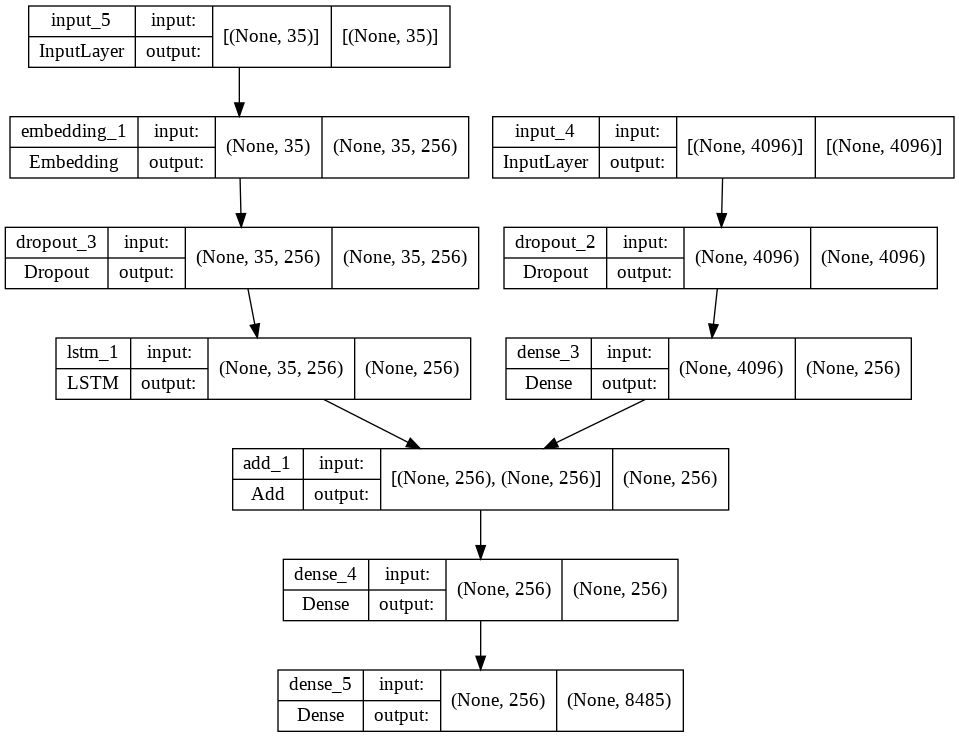

In [31]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='Adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# # train the model
# epochs = 1
# batch_size = 32
# steps = len(train) // batch_size

# history_loss = []

# for i in range(epochs):
#     # create data generator
#     generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
#     # fit for one epoch
#     history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     history_loss.append(history.history['loss'])

# # save the model
# model.save(WORKING_DIR+'/best_model_parameters_categorical_crossentropy_Adam.h5')

# # Saving the loss
# error = pd.DataFrame(history_loss)
# error.to_csv('Loss_Adam.csv')


In [32]:
from tensorflow import keras
model = keras.models.load_model('/content/flickr8k/FlickerAllData/best_model.h5')
print(model)

#5) **Performance metric of the algorithm**

Note: We have saved all the performance metrics so we are just loading it from our saved files and showing it

### **1) Loss VS Epoch**

Explaination: epoch refers to the passing of whole dataset through the network; that will be counted as one epoch. So in the metric we will see how is the loss of the model in each epoch and get to know if we need to train our model for more epoch's

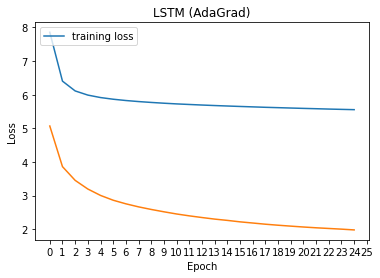

In [36]:
LSTM_Loss_Adagrad = pd.read_csv('/content/Loss_Adagrad.csv')
GRU_Loss_Adam = pd.read_csv('/content/GRU_Loss_Adam.csv')
plt.plot(LSTM_Loss_Adagrad['0'])
plt.plot(GRU_Loss_Adam['0'])
plt.xticks([i for i in range(0, 26)])
plt.title('LSTM (AdaGrad)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss'], loc='upper left')
plt.show()

In [42]:
df = px.data.gapminder().query("country=='Canada'")

In [43]:
df

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
240,Canada,Americas,1952,68.750,14785584,11367.16112,CAN,124
241,Canada,Americas,1957,69.960,17010154,12489.95006,CAN,124
242,Canada,Americas,1962,71.300,18985849,13462.48555,CAN,124
243,Canada,Americas,1967,72.130,20819767,16076.58803,CAN,124
244,Canada,Americas,1972,72.880,22284500,18970.57086,CAN,124
245,Canada,Americas,1977,74.210,23796400,22090.88306,CAN,124
246,Canada,Americas,1982,75.760,25201900,22898.79214,CAN,124
247,Canada,Americas,1987,76.860,26549700,26626.51503,CAN,124
248,Canada,Americas,1992,77.950,28523502,26342.88426,CAN,124
249,Canada,Americas,1997,78.610,30305843,28954.92589,CAN,124


In [49]:
import plotly.express as px
Loss_Comprehensive = pd.read_csv('/content/Loss_Comprehensive.csv')
fig = px.line(Loss_Comprehensive,x = 'Epoch',y = 'Loss' , color='Algorithm' , title='Loss VS Epoch')
fig.show()

In [34]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

def calculate_bleu(model,test,tokenizer,max_length):
  actual, predicted = list(), list()
  for key in tqdm(test):
      # get actual caption
      captions = mapping[key]
      # predict the caption for image
      y_pred = predict_caption(model, features[key], tokenizer, max_length) 
      # split into words
      actual_captions = [caption.split() for caption in captions]
      y_pred = y_pred.split()
      # append to the list
      actual.append(actual_captions)
      predicted.append(y_pred)
  # calcuate BLEU score
  print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
  print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man and boy play music as little girls watch endseq
startseq man is playing guitar with child playing harmonica while three young girls watch endseq
startseq three children watch man onstage playing guitar endseq
startseq three little girls look on as boy plays the harmonica with an adult guiutarist sitting beside him endseq
startseq three little girls watch band endseq
--------------------Predicted--------------------
startseq man playing guitar shows picture of man endseq


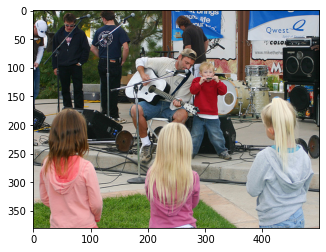

In [35]:
generate_caption("2095478050_736c4d2d28.jpg")